<i>Copyright (c) Microsoft Corporation.</i>

<i>Licensed under the MIT License.</i>

# Dilated Convolutional Neural Network (CNN)

This notebook introduces Dilated Convolutional Neural Network (CNN) model and carries out multi-round training and evaluation of this model on the Orange Juice dataset.

The Dilated CNN is built upon dilated causal convolution inspired by [WaveNet](https://arxiv.org/abs/1609.03499). [Recently study](https://arxiv.org/abs/1803.01271) shows that it outperforms canonical recurrent networks such as LSTMs over a diverse range of tasks and datasets. Dilated CNN has many advantages when handling sequential data like time series
* Capturing long-range input information with less parameters
* Handling temporal flow with causal connection structures
* Better training efficiency than recurrent neural networks

Dilated CNN has been applied in several machine learning competitions and achieved impressive performance, e.g. [the Favorita Grocery Sales Forecasting competition](https://github.com/LenzDu/Kaggle-Competition-Favorita).

## Global Settings and Imports

In [1]:
%load_ext tensorboard

In [2]:
import os
import sys
import math
import shutil
import random
import datetime
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import scrapbook as sb

from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from fclib.common.utils import git_repo_path, module_path
from fclib.dataset.ojdata import download_ojdata, split_train_test, FIRST_WEEK_START
from fclib.feature_engineering.feature_utils import (
    week_of_month,
    df_from_cartesian_product,
    gen_sequence_array,
    static_feature_array,
    normalize_columns,
)
from fclib.models.dilated_cnn import create_dcnn_model
from fclib.evaluation.evaluation_utils import MAPE
from fclib.common.plot import plot_predictions_with_history

warnings.filterwarnings("ignore")

print("System version: {}".format(sys.version))
print("TensorFlow version: {}".format(tf.__version__))

System version: 3.6.10 |Anaconda, Inc.| (default, Mar 23 2020, 23:13:11) 
[GCC 7.3.0]
TensorFlow version: 2.0.0


## Parameter Settings

In the following cell, we define global settings related to the model and feature engineering. We initialize several key parameters of the model including `SEQ_LEN` and `DROPOUT_RATE` that decide the deep learning network structure as well as `BATCH_SIZE`, `LEARNING_RATE`, and `EPOCHS` that control the optimization algorithm. We use historical data of a number of dynamic features and several static features to form input sequences to the model. The dynamic features include `deal`, `feat`, `month`, `week_of_month`, `price`, `price_ratio`; while the static features are `store` and `brand`.

In [3]:
# Use False if you've already downloaded and split the data
DOWNLOAD_SPLIT_DATA = True

# Data directories
DATA_DIR = os.path.join(git_repo_path(), "ojdata")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Forecasting settings
N_SPLITS = 10
HORIZON = 2
GAP = 2
FIRST_WEEK = 40
LAST_WEEK = 156

# Parameters of the model
SEQ_LEN = 15
DROPOUT_RATE = 0.01
BATCH_SIZE = 64
LEARNING_RATE = 0.015
EPOCHS = 25

# Feature columns
DYNAMIC_FEATURES = ["deal", "feat", "month", "week_of_month", "price", "price_ratio"]
STATIC_FEATURES = ["store", "brand"]

# Maximum store ID and brand ID
MAX_STORE_ID = 137
MAX_BRAND_ID = 11

We also fix random seeds so that the results obtained by Dilated CNN can be reproduced.

In [4]:
# Fix random seeds
random.seed(2)
np.random.seed(2)
tf.random.set_seed(2)

## Data Preparation

We need to download the Orange Juice data and split it into training and test sets for multiple forecast rounds. By default, the following cell will download and spit the data. If you've already done so, you may skip this part by changing `DOWNLOAD_SPLIT_DATA` to False.

In [5]:
if DOWNLOAD_SPLIT_DATA:
    download_ojdata(DATA_DIR)
    split_train_test(
        DATA_DIR,
        n_splits=N_SPLITS,
        horizon=HORIZON,
        gap=GAP,
        first_week=FIRST_WEEK,
        last_week=LAST_WEEK,
        write_csv=True,
    )
    print("Finished data downloading and splitting.")

Data already exists at the specified location.
Finished data downloading and splitting.


## Feature Engineering

Next we create a function to extract a number of features from the data for training the forecasting model. These features can be divided into dynamic features and static features:

* Dynamic features:
    - datetime features including week of the month, month, etc.
    - historical weekly sales of each orange juice in recent weeks
    - absolute price and the ratio between absolute price and average price of all brands
    - promotion information captured by `deal` and `feat` columns
* Static features:
    - store ID and brand ID

Note that the logarithm of the unit sales is stored in a column named `logmove` both for `train_df` and `test_df`. We compute the unit sales `move` based on this quantity and treat the unit sales as the prediction target.

In [6]:
def create_features(pred_round, train_dir, pred_steps, offset):
    """Create a dataframe of the input features.
    
    Args: 
        pred_round (int): Prediction round (1, 2, ...)
        train_dir (str): Path of the training data directory
        pred_steps (int): Number of prediction steps
        offset (int): Length of training data skipped in retraining

    Returns:
        pd.Dataframe: Dataframe including the input features in original scale
        pd.Dataframe: Dataframe including the normalized features 
        int: Last week of the training data 
    """
    # Load training data
    train_df = pd.read_csv(os.path.join(TRAIN_DIR, "train_" + str(pred_round) + ".csv"))
    train_df["move"] = train_df["logmove"].apply(lambda x: round(math.exp(x)))
    train_df = train_df[["store", "brand", "week", "move"]]

    # Create a dataframe to hold all necessary data
    store_list = train_df["store"].unique()
    brand_list = train_df["brand"].unique()
    train_end_week = train_df["week"].max()
    week_list = range(FIRST_WEEK + offset, train_end_week + GAP + HORIZON)
    d = {"store": store_list, "brand": brand_list, "week": week_list}
    data_grid = df_from_cartesian_product(d)
    data_filled = pd.merge(data_grid, train_df, how="left", on=["store", "brand", "week"])

    # Get future price, deal, and advertisement info
    aux_df = pd.read_csv(os.path.join(TRAIN_DIR, "auxi_" + str(pred_round) + ".csv"))
    data_filled = pd.merge(data_filled, aux_df, how="left", on=["store", "brand", "week"])

    # Create relative price feature
    price_cols = [
        "price1",
        "price2",
        "price3",
        "price4",
        "price5",
        "price6",
        "price7",
        "price8",
        "price9",
        "price10",
        "price11",
    ]
    data_filled["price"] = data_filled.apply(lambda x: x.loc["price" + str(int(x.loc["brand"]))], axis=1)
    data_filled["avg_price"] = data_filled[price_cols].sum(axis=1).apply(lambda x: x / len(price_cols))
    data_filled["price_ratio"] = data_filled["price"] / data_filled["avg_price"]
    data_filled.drop(price_cols, axis=1, inplace=True)

    # Fill missing values
    data_filled = data_filled.groupby(["store", "brand"]).apply(
        lambda x: x.fillna(method="ffill").fillna(method="bfill")
    )

    # Create datetime features
    data_filled["week_start"] = data_filled["week"].apply(
        lambda x: FIRST_WEEK_START + datetime.timedelta(days=(x - 1) * 7)
    )
    data_filled["month"] = data_filled["week_start"].apply(lambda x: x.month)
    data_filled["week_of_month"] = data_filled["week_start"].apply(lambda x: week_of_month(x))
    data_filled["day"] = data_filled["week_start"].apply(lambda x: x.day)
    data_filled.drop("week_start", axis=1, inplace=True)

    # Normalize the dataframe of features
    cols_normalize = data_filled.columns.difference(["store", "brand", "week"])
    data_scaled, min_max_scaler = normalize_columns(data_filled, cols_normalize)

    return data_filled, data_scaled, train_end_week

## Modeling

We then perform a multi-round training by fitting a Dilated CNN model using the training data in each forecast round. To speed up the training process, we only train the model on full training set in the first round. In the subsequent rounds, the model will be retrained using the latest data. After the model is trained in each round, it is applied to generate forecasts for the target weeks.

We use a utility function `create_dcnn_model()` to define the Dilated CNN. As introduced in [literature](https://arxiv.org/abs/1609.03499), the core structure of the Dilated CNN is a stack of dilated causal convolutional layers. Below is an example of such stack involving 4 dilated convolutional layers.

<img src="https://user-images.githubusercontent.com/20047467/75483041-f6814700-5973-11ea-8e76-91ce39aed8ba.png" width="720" height="450">

The number of dilated layers can be specified via input argument `n_dilated_layers` of the model definition utility function. After creating the model, we can print out the structure of the network via executing `model.summary()`.

<img src="https://user-images.githubusercontent.com/20047467/75485586-f6377a80-5978-11ea-9a6f-547005a6a10e.png" width="720" height="1000">

### Prepare Input and Output

Next, we define two functions that help prepare input and output data for model training and testing.

In [7]:
def prepare_training_io(data_filled, data_scaled, train_end_week):
    """Prepare input and output for model training.
    
    Args: 
        data_filled (pd.Dataframe): Dataframe including the input features in original scale
        data_scaled (pd.Dataframe): Dataframe including the normalized features 
        train_end_week (int): Last week of the training data

    Returns:
        np.array: Input sequences of dynamic features
        np.array: Input sequences of categorical features
        np.array: Output sequences of the target variable
    """
    # Create sequence array for 'move'
    start_timestep = 0
    end_timestep = train_end_week - FIRST_WEEK - HORIZON - GAP + 1
    train_input1 = gen_sequence_array(
        data_scaled, SEQ_LEN, ["move"], "store", "brand", start_timestep, end_timestep - offset,
    )

    # Create sequence array for other dynamic features
    start_timestep = HORIZON + GAP - 1
    end_timestep = train_end_week - FIRST_WEEK
    train_input2 = gen_sequence_array(
        data_scaled, SEQ_LEN, DYNAMIC_FEATURES, "store", "brand", start_timestep, end_timestep - offset,
    )

    seq_in = np.concatenate((train_input1, train_input2), axis=2)

    # Create array of static features
    total_timesteps = train_end_week - FIRST_WEEK - SEQ_LEN - HORIZON - GAP + 3
    cat_fea_in = static_feature_array(data_filled, total_timesteps - offset, STATIC_FEATURES, "store", "brand")

    # Create training output
    start_timestep = SEQ_LEN + GAP - 1
    end_timestep = train_end_week - FIRST_WEEK
    train_output = gen_sequence_array(
        data_filled, HORIZON, ["move"], "store", "brand", start_timestep, end_timestep - offset,
    )
    train_output = np.squeeze(train_output)

    return seq_in, cat_fea_in, train_output

In [8]:
def prepare_testing_io(data_filled, data_scaled, train_end_week):
    """Prepare input and output for model training.
    
    Args: 
        data_filled (pd.Dataframe): Dataframe including the input features in original scale
        data_scaled (pd.Dataframe): Dataframe including the normalized features 
        train_end_week (int): Last week of the training data

    Returns:
        np.array: Input sequences of dynamic features
        np.array: Input sequences of categorical features
    """
    # Get inputs for prediction
    start_timestep = train_end_week - FIRST_WEEK - SEQ_LEN + 1
    end_timestep = train_end_week - FIRST_WEEK
    test_input1 = gen_sequence_array(
        data_scaled, SEQ_LEN, ["move"], "store", "brand", start_timestep - offset, end_timestep - offset,
    )

    start_timestep = train_end_week + GAP + HORIZON - FIRST_WEEK - SEQ_LEN
    end_timestep = train_end_week + GAP + HORIZON - FIRST_WEEK - 1
    test_input2 = gen_sequence_array(
        data_scaled, SEQ_LEN, DYNAMIC_FEATURES, "store", "brand", start_timestep - offset, end_timestep - offset,
    )

    seq_in = np.concatenate((test_input1, test_input2), axis=2)

    total_timesteps = 1
    cat_fea_in = static_feature_array(data_filled, total_timesteps, STATIC_FEATURES, "store", "brand")

    return seq_in, cat_fea_in

### Model Training and Prediction

With the above helper functions, now we are ready for model training and applying the trained model to generate predictions. We save the training log information in the directory `log_dir` so that we can visualize the training process with [TensorBoard](https://www.tensorflow.org/tensorboard/get_started), which is a tool for providing the measurements and visualizations needed during the machine learning workflow.

In [9]:
%%time

# Model file name and log directory
model_file_name = "dcnn_model.h5"
log_dir = os.path.join("logs", "scalars")

# Remove log directory if it exists
if os.path.isdir(log_dir):
    shutil.rmtree(log_dir)
    print("Removed existing log directory {} \n".format(log_dir))

# Train models and make predictions
pred_all = []
for r in range(1, N_SPLITS + 1):
    print("---- Round " + str(r) + " ----")
    # Use offset to remove older data during retraining
    offset = 0 if r == 1 else 40 + (r - 1) * HORIZON
    # Create features
    data_filled, data_scaled, train_end_week = create_features(r, TRAIN_DIR, HORIZON, offset)

    # Prepare input and output for model training
    seq_in, cat_fea_in, train_output = prepare_training_io(data_filled, data_scaled, train_end_week)

    # Create and train model
    if r == 1:
        model = create_dcnn_model(
            seq_len=SEQ_LEN,
            n_dyn_fea=1 + len(DYNAMIC_FEATURES),
            n_outputs=HORIZON,
            n_dilated_layers=3,
            kernel_size=2,
            n_filters=3,
            dropout_rate=DROPOUT_RATE,
            max_cat_id=[MAX_STORE_ID, MAX_BRAND_ID],
        )
        adam = optimizers.Adam(lr=LEARNING_RATE)
        model.compile(loss="mape", optimizer=adam, metrics=["mape", "mae"])
        # Define checkpoint and fit model
        checkpoint = ModelCheckpoint(model_file_name, monitor="loss", save_best_only=True, mode="min", verbose=1)
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")), histogram_freq=1,
        )
        callbacks_list = [checkpoint, tensorboard_callback]
        history = model.fit(
            [seq_in, cat_fea_in],
            train_output,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=callbacks_list,
            verbose=1,
        )
    else:
        model = load_model(model_file_name)
        checkpoint = ModelCheckpoint(model_file_name, monitor="loss", save_best_only=True, mode="min", verbose=1)
        callbacks_list = [checkpoint]
        history = model.fit(
            [seq_in, cat_fea_in], train_output, epochs=1, batch_size=BATCH_SIZE, callbacks=callbacks_list, verbose=1,
        )

    # Prepare input for model testing
    seq_in, cat_fea_in = prepare_testing_io(data_filled, data_scaled, train_end_week)

    # Make prediction
    pred = np.round(model.predict([seq_in, cat_fea_in]))

    # Create dataframe for submission
    exp_output = data_filled[data_filled.week >= train_end_week + GAP].reset_index(drop=True)
    exp_output = exp_output[["store", "brand", "week"]]
    pred_df = (
        exp_output.sort_values(["store", "brand", "week"]).loc[:, ["store", "brand", "week"]].reset_index(drop=True)
    )
    pred_df["round"] = r
    pred_df["prediction"] = np.reshape(pred, (pred.size, 1))
    pred_all.append(pred_df)

    # Show the current predictions
    print("\n Prediction results:")
    print(pred_df.head(5))
    print("")

pred_all = pd.concat(pred_all, axis=0)
pred_all.rename(columns={"move": "prediction"}, inplace=True)
pred_all = pred_all[["round", "week", "store", "brand", "prediction"]]

---- Round 1 ----
Train on 72127 samples
Epoch 1/25
71616/72127 [============================>.] - ETA: 0s - loss: 56.5520 - mape: 56.5520 - mae: 7724.2822
Epoch 00001: loss improved from inf to 56.51509, saving model to dcnn_model.h5
72127/72127 [==============================] - 6s 84us/sample - loss: 56.5151 - mape: 56.5151 - mae: 7720.3770
Epoch 2/25
71808/72127 [============================>.] - ETA: 0s - loss: 47.1695 - mape: 47.1694 - mae: 7017.5864
Epoch 00002: loss improved from 56.51509 to 47.16605, saving model to dcnn_model.h5
72127/72127 [==============================] - 4s 49us/sample - loss: 47.1660 - mape: 47.1660 - mae: 7016.5732
Epoch 3/25
71808/72127 [============================>.] - ETA: 0s - loss: 45.7213 - mape: 45.7213 - mae: 6850.9878
Epoch 00003: loss improved from 47.16605 to 45.71347, saving model to dcnn_model.h5
72127/72127 [==============================] - 4s 50us/sample - loss: 45.7135 - mape: 45.7135 - mae: 6850.3550
Epoch 4/25
71424/72127 [==========

35607/35607 [==============================] - 2s 70us/sample - loss: 33.9260 - mape: 33.9260 - mae: 5309.5166

 Prediction results:
   store  brand  week  round  prediction
0      2      1   139      2      3998.0
1      2      1   140      2      4596.0
2      2      2   139      2      6158.0
3      2      2   140      2      6448.0
4      2      3   139      2      1554.0

---- Round 3 ----
Train on 35607 samples
34752/35607 [============================>.] - ETA: 0s - loss: 33.5213 - mape: 33.5213 - mae: 5126.2217
Epoch 00001: loss improved from inf to 33.46539, saving model to dcnn_model.h5
35607/35607 [==============================] - 3s 72us/sample - loss: 33.4654 - mape: 33.4654 - mae: 5107.3125

 Prediction results:
   store  brand  week  round  prediction
0      2      1   141      3      6915.0
1      2      1   142      3      6761.0
2      2      2   141      3      5557.0
3      2      2   142      3      6409.0
4      2      3   141      3      1428.0

---- Round 4 ---

### TensorBoard Monitor (Optional)

We can monitor the model training process from TensorBoard. In the cell below, please switch `CHECK_TENSORBOARD` to True if you want to do so. Note that the following cell will try to find the path of the TensorBoard binary if it is not specified. In case the path can't be found, you can run `which tensorboard` (for Linux) or `where tensorboard` (for Windows) from a terminal where `forecasting_env` is activated to look for the path and replace the TensorBoard path in the second line of the code with the path that you find. 

To view the TensorBoard, you will need to forward port 6008 to your local machine via `ssh <user-name>@<remote-vm-ip-address> -L 6008:localhost:6008` if you're running this notebook in a remote VW. On the Tensorboard, you will see a dashboard similar to the following one:

<img src="https://user-images.githubusercontent.com/20047467/75494844-24be5100-598b-11ea-97ea-96b32373e75d.png" width="720" height="800">

In [10]:
CHECK_TENSORBOARD = False
tensorboard_path = "" # Replace this with the path you find from terminal
if CHECK_TENSORBOARD:
    if not tensorboard_path:
        # Try to find path of the TensorBoard binary
        tensorboard_path = module_path("forecasting_env", "tensorboard")
    if tensorboard_path:
        os.environ["TENSORBOARD_BINARY"] = tensorboard_path
        # Display TensorBoard
        %tensorboard --logdir logs/scalars --port 6008
    else:
        print("Can't find TensorBoard binary. TensorBoard visualization is skipped.")

## Model Evaluation

To evaluate the performance of the model, we compute MAPE of the forecasts from all the forecast rounds below.

In [11]:
# Evaluate prediction accuracy
test_all = []
test_dir = os.path.join(DATA_DIR, "test")
for r in range(1, N_SPLITS + 1):
    test_df = pd.read_csv(os.path.join(test_dir, "test_" + str(r) + ".csv"))
    test_all.append(test_df)
test_all = pd.concat(test_all, axis=0).reset_index(drop=True)
test_all["actual"] = test_all["logmove"].apply(lambda x: round(math.exp(x)))
test_all.drop("logmove", axis=1, inplace=True)
combined = pd.merge(pred_all, test_all, on=["store", "brand", "week"], how="left")
metric_value = MAPE(combined["prediction"], combined["actual"]) * 100
sb.glue("MAPE", metric_value)
print("MAPE of the predictions is {}".format(metric_value))

MAPE of the predictions is 37.66172255231067


## Result Visualization

Let's visually check the forecasts by plotting out the forecast results of a few sample store-brand combinations. Note that there could be gaps in the curve of actual sales due to missing sales data.

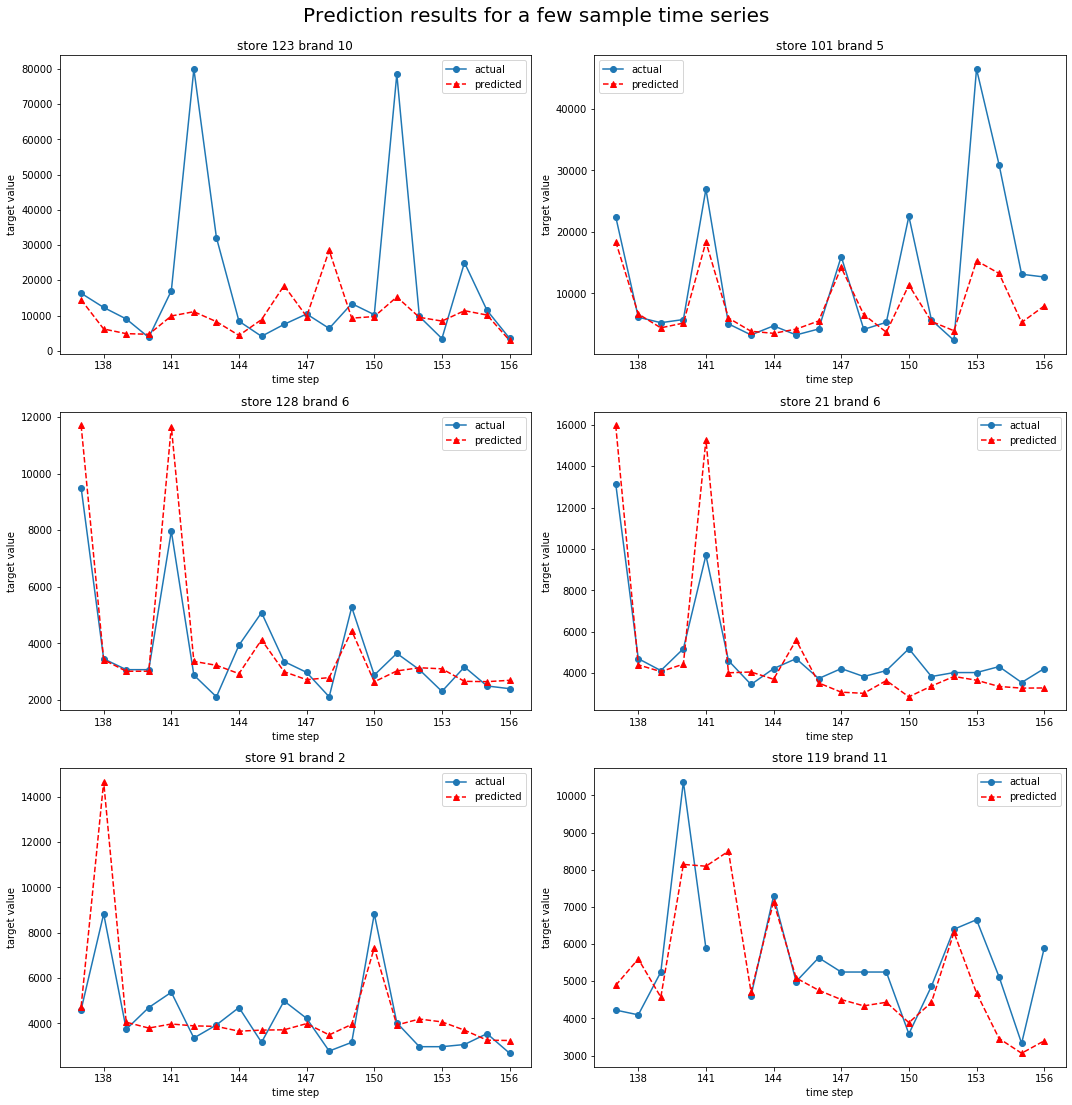

In [12]:
results = combined[["week", "store", "brand", "prediction"]]
results.rename(columns={"prediction": "move"}, inplace=True)
actual = combined[["week", "store", "brand", "actual"]]
actual.rename(columns={"actual": "move"}, inplace=True)
store_list = combined["store"].unique()
brand_list = combined["brand"].unique()

plot_predictions_with_history(
    results,
    actual,
    store_list,
    brand_list,
    "week",
    "move",
    grain1_name="store",
    grain2_name="brand",
    min_timestep=137,
    num_samples=6,
    predict_at_timestep=135,
    line_at_predict_time=False,
    title="Prediction results for a few sample time series",
    x_label="time step",
    y_label="target value",
    random_seed=6,
)

## Additional Reading

\[1\] Aaron van den Oord, Sander Dieleman, Heiga Zen, Karen Simonyan, Oriol Vinyals, Alex Graves, Nal Kalchbrenner, Andrew Senior, and Koray Kavukcuoglu. 2016. WaveNet: A Generative Model for Raw Audio. arXiv preprint
arXiv:1609.03499 (2016)<br>

\[2\] Shaojie Bai, J. Zico Kolter, and Vladlen Koltun. 2018. An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling. arXiv preprint arXiv:1803.01271 (2018)<br>